In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
img_height, img_width = 48, 48  # common FER image size
batch_size = 32
num_classes = 7  # angry, disgust, fear, happy, neutral, sad, surprise

# Paths
train_dir = 'Dataset/train'
test_dir = 'Dataset/test'

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# CNN Model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

d:\Studies\Research\Human-Emotion-Recognition\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_data,
    epochs=50,  # Increased for better EarlyStopping performance
    validation_data=test_data,
    callbacks=[early_stop, model_checkpoint, reduce_lr]
)

# Save model
model.save("emotion_model.h5")

d:\Studies\Research\Human-Emotion-Recognition\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.2425 - loss: 1.8222

898/898 ━━━━━━━━━━━━━━━━━━━━ 300s 332ms/step - accuracy: 0.2426 - loss: 1.8222 - val_accuracy: 0.3107 - val_loss: 1.6687 - learning_rate: 0.0010
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3289 - loss: 1.6845

898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.3289 - loss: 1.6845 - val_accuracy: 0.4298 - val_loss: 1.4656 - learning_rate: 0.0010
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3991 - loss: 1.5506

898/898 ━━━━━━━━━━━━━━━━━━━━ 85s 95ms/step - accuracy: 0.3991 - loss: 1.5506 - val_accuracy: 0.4692 - val_loss: 1.3641 - learning_rate: 0.0010
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4389 - loss: 1.4573

898/898 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.4389 - loss: 1.4573 - val_accuracy: 0.4951 - val_loss: 1.3096 - learning_rate: 0.0010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4689 - loss: 1.3917

898/898 ━━━━━━━━━━━━━━━━━━━━ 85s 95ms/step - accuracy: 0.4689 - loss: 1.3917 - val_accuracy: 0.5116 - val_loss: 1.2698 - learning_rate: 0.0010
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4863 - loss: 1.3580

898/898 ━━━━━━━━━━━━━━━━━━━━ 104s 115ms/step - accuracy: 0.4863 - loss: 1.3580 - val_accuracy: 0.5212 - val_loss: 1.2516 - learning_rate: 0.0010
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5018 - loss: 1.3149

898/898 ━━━━━━━━━━━━━━━━━━━━ 95s 106ms/step - accuracy: 0.5018 - loss: 1.3149 - val_accuracy: 0.5358 - val_loss: 1.2138 - learning_rate: 0.0010
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5032 - loss: 1.3051

898/898 ━━━━━━━━━━━━━━━━━━━━ 84s 94ms/step - accuracy: 0.5032 - loss: 1.3051 - val_accuracy: 0.5446 - val_loss: 1.1860 - learning_rate: 0.0010
Epoch 9/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 87s 97ms/step - accuracy: 0.5134 - loss: 1.2839 - val_accuracy: 0.5371 - val_loss: 1.2025 - learning_rate: 0.0010
Epoch 10/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5190 - loss: 1.2663

898/898 ━━━━━━━━━━━━━━━━━━━━ 85s 95ms/step - accuracy: 0.5190 - loss: 1.2663 - val_accuracy: 0.5545 - val_loss: 1.1700 - learning_rate: 0.0010
Epoch 11/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 88s 97ms/step - accuracy: 0.5220 - loss: 1.2608 - val_accuracy: 0.5442 - val_loss: 1.1806 - learning_rate: 0.0010
Epoch 12/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5249 - loss: 1.2488

898/898 ━━━━━━━━━━━━━━━━━━━━ 85s 95ms/step - accuracy: 0.5249 - loss: 1.2488 - val_accuracy: 0.5560 - val_loss: 1.1507 - learning_rate: 0.0010
Epoch 13/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5355 - loss: 1.2403

898/898 ━━━━━━━━━━━━━━━━━━━━ 87s 97ms/step - accuracy: 0.5355 - loss: 1.2403 - val_accuracy: 0.5627 - val_loss: 1.1383 - learning_rate: 0.0010
Epoch 14/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 86s 96ms/step - accuracy: 0.5344 - loss: 1.2190 - val_accuracy: 0.5424 - val_loss: 1.1838 - learning_rate: 0.0010
Epoch 15/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5404 - loss: 1.2094

898/898 ━━━━━━━━━━━━━━━━━━━━ 78s 87ms/step - accuracy: 0.5404 - loss: 1.2094 - val_accuracy: 0.5691 - val_loss: 1.1259 - learning_rate: 0.0010
Epoch 16/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 70s 78ms/step - accuracy: 0.5453 - loss: 1.1870 - val_accuracy: 0.5561 - val_loss: 1.1579 - learning_rate: 0.0010
Epoch 17/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.5393 - loss: 1.1943 - val_accuracy: 0.5722 - val_loss: 1.1259 - learning_rate: 0.0010
Epoch 18/50
 44/898 ━━━━━━━━━━━━━━━━━━━━ 1:05 76ms/step - accuracy: 0.5205 - loss: 1.2654

KeyboardInterrupt: 

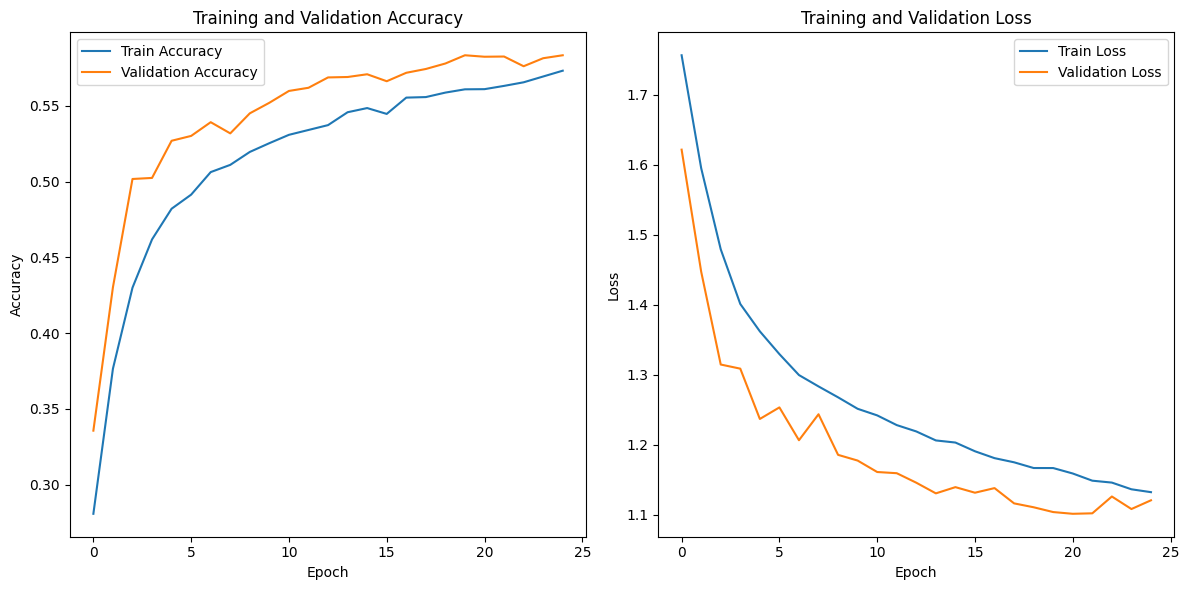

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


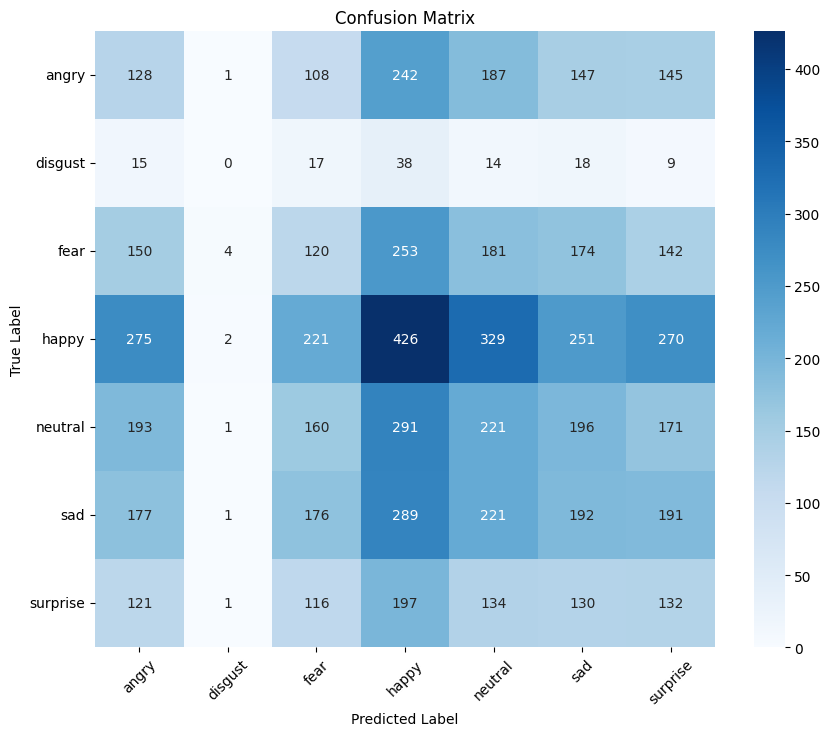

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.13      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.12      0.12      1024
       happy       0.25      0.24      0.24      1774
     neutral       0.17      0.18      0.18      1233
         sad       0.17      0.15      0.16      1247
    surprise       0.12      0.16      0.14       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [ ]:
# 1. Training Metrics (Accuracy/Loss Curves)
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Confusion Matrix and Classification Report
# Reset test generator and get predictions
test_data.reset()
y_pred = model.predict(test_data, verbose=1)
y_pred = y_pred[:test_data.samples]  # Ensure correct length
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
true_classes = test_data.classes
class_names = list(train_data.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Classification report
print("Classification Report:\n", classification_report(true_classes, y_pred_classes, target_names=class_names))